In [3]:
import numpy as np
import pandas as pd
from collections import deque
import ast
import os
import glob
from pathlib import Path
from modeling_parameters.config import (
    PRIM_PARTICLE, 
    THETA,
    COORDINATES_PATH,
    RECONSTRUCTION_GEANT_OUTPUT_DIR,
    MATPLOTLIBRC_PATH,
    CENTRAL_STATIONS,
    PLOTS_GEANT_DIR,
    READ_GEANT_OUTPUT_DIR,
)

import matplotlib as mpl
mpl.rc_file(MATPLOTLIBRC_PATH)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from modeling_parameters.reconstruction.geant.functions import(
     compute_r,
     rho_model,
)

from functions import (
    plot_two_distributions_by_name,
    plot_single_distribution_by_name,
    plot_single_distribution_Ne,
    plot_two_distributions_Ne,
    ast_df,
    process_df,
)

In [4]:
coordinates_df = pd.read_csv(COORDINATES_PATH)

X_det = np.array(coordinates_df['X'])
Y_det = np.array(coordinates_df['Y'])
Z_det = np.array(coordinates_df['Z'])

In [8]:
folder_path = Path(RECONSTRUCTION_GEANT_OUTPUT_DIR)
files = sorted(f for f in folder_path.iterdir() if f.is_file())

def get_file_by_index(index):
    if 0 <= index < len(files):
        return files[index]
    else:
        return None  

index = 0
file = get_file_by_index(index)

if file is not None:
    print(f"Файл с индексом {index}: {file}")
else:
    print(f"Нет файла с индексом {index}")
# file_name = file.stem 
# E = int(file_name.split('p')[1][:2]) 

Файл с индексом 0: d:\github\repositories\sdf\modeling_parameters\reconstruction\geant\output\spe27\spe27_reconstruction.csv


In [9]:
df = pd.read_csv(file)
ast_df(df)
df.head(1)

,theta,phi,X0,Y0,Ne,s,r,rho,mask,worked_clusters,worked_stations,X0_opt,Y0_opt,Ne_opt,s_opt,loss
0,34.48944,32.536682,-28.167313,19.411396,1457.951,1.379656,"[16.61397516629336, 19.991758357620746, 30.339...","[0.43410485292353274, 0.31512107972691694]","[False, False, False, False, False, False, Fal...",[6],"[20, 21]",47.358273,-15.602519,78080.559922,0.247998,0.0


In [38]:
min_st = 5
top_k = 2

In [39]:
arrays = process_df(df, X_det, Y_det, Z_det, min_clusters=min_st, top_k=top_k)

In [40]:
E = 15

In [41]:
who = 'r'
ymax = 0.2
limit = 100
bin_width =  10
save = False

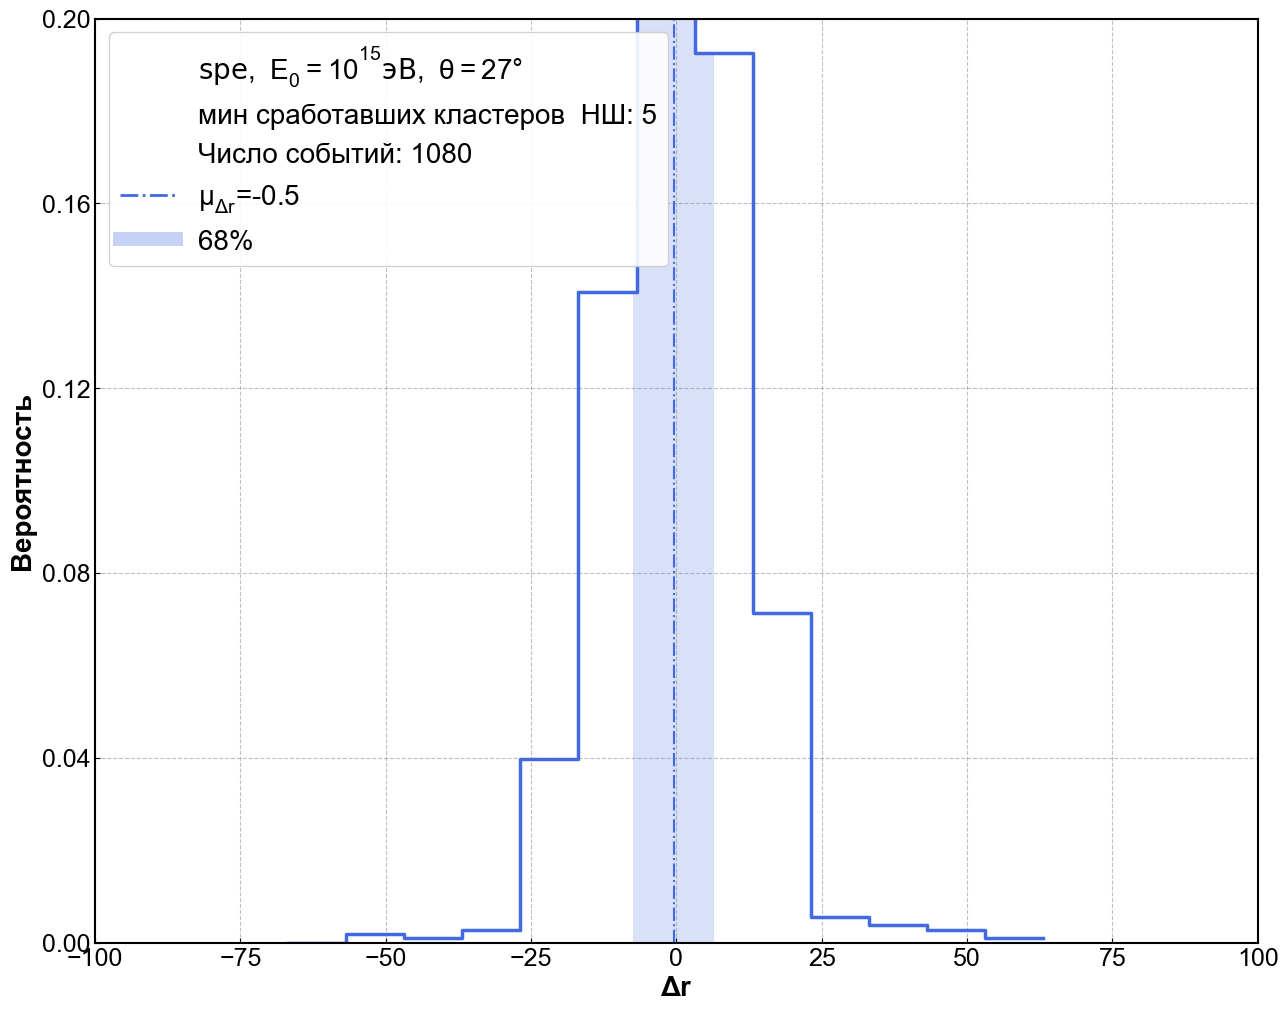

In [42]:
plot_single_distribution_by_name(arrays, who, E, limit, bin_width, min_st, top_k, ymax, save)

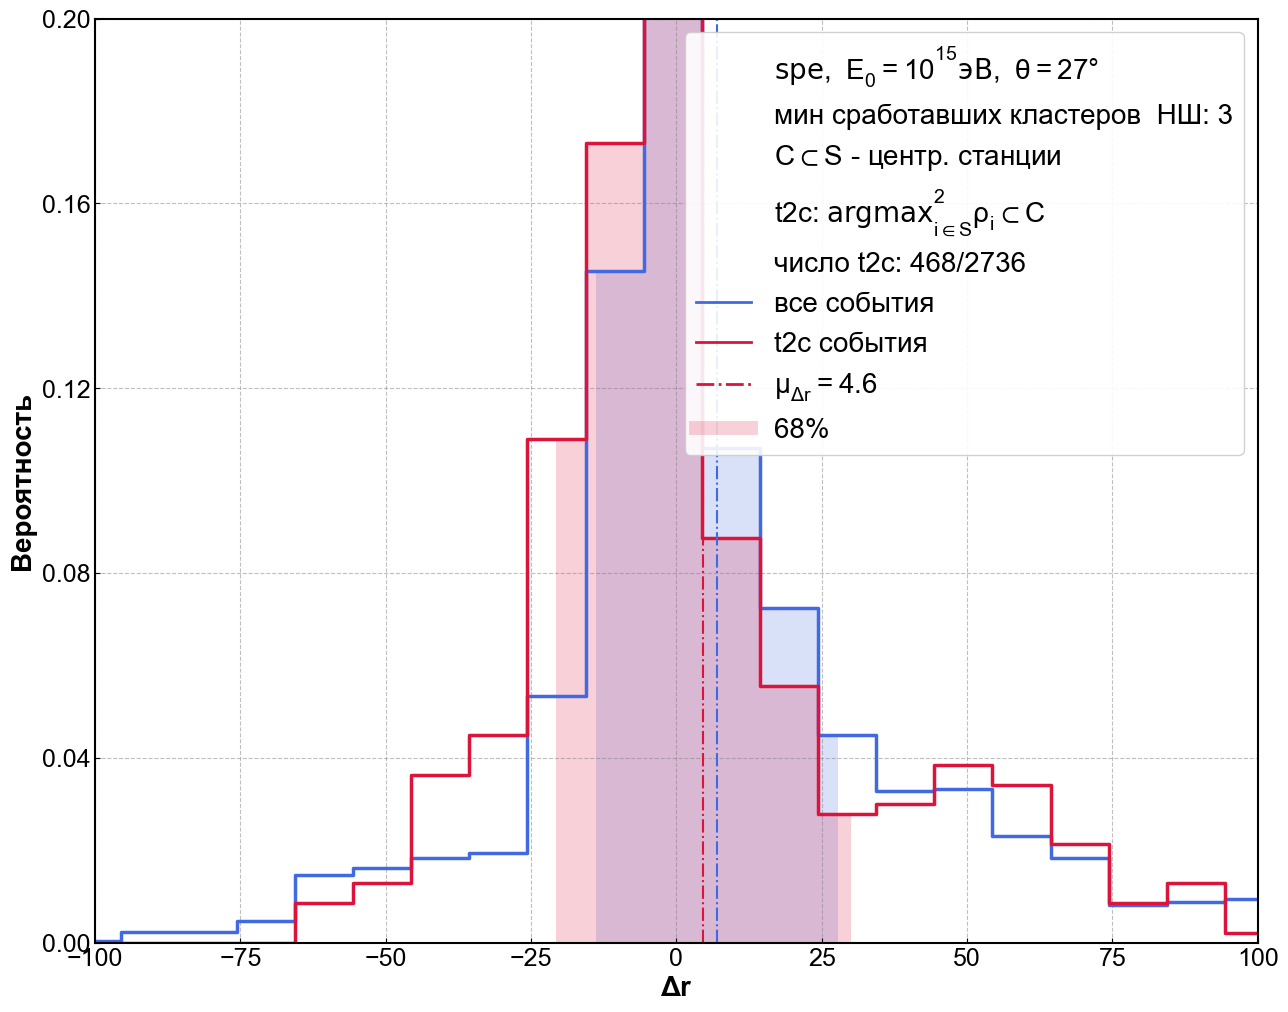

In [37]:
plot_two_distributions_by_name(arrays, who, E, limit, bin_width, min_st, top_k, ymax, save)

## $N_e$

In [241]:
limit = 0.4
ymax = 0.7
bin_width = 0.05
save = False

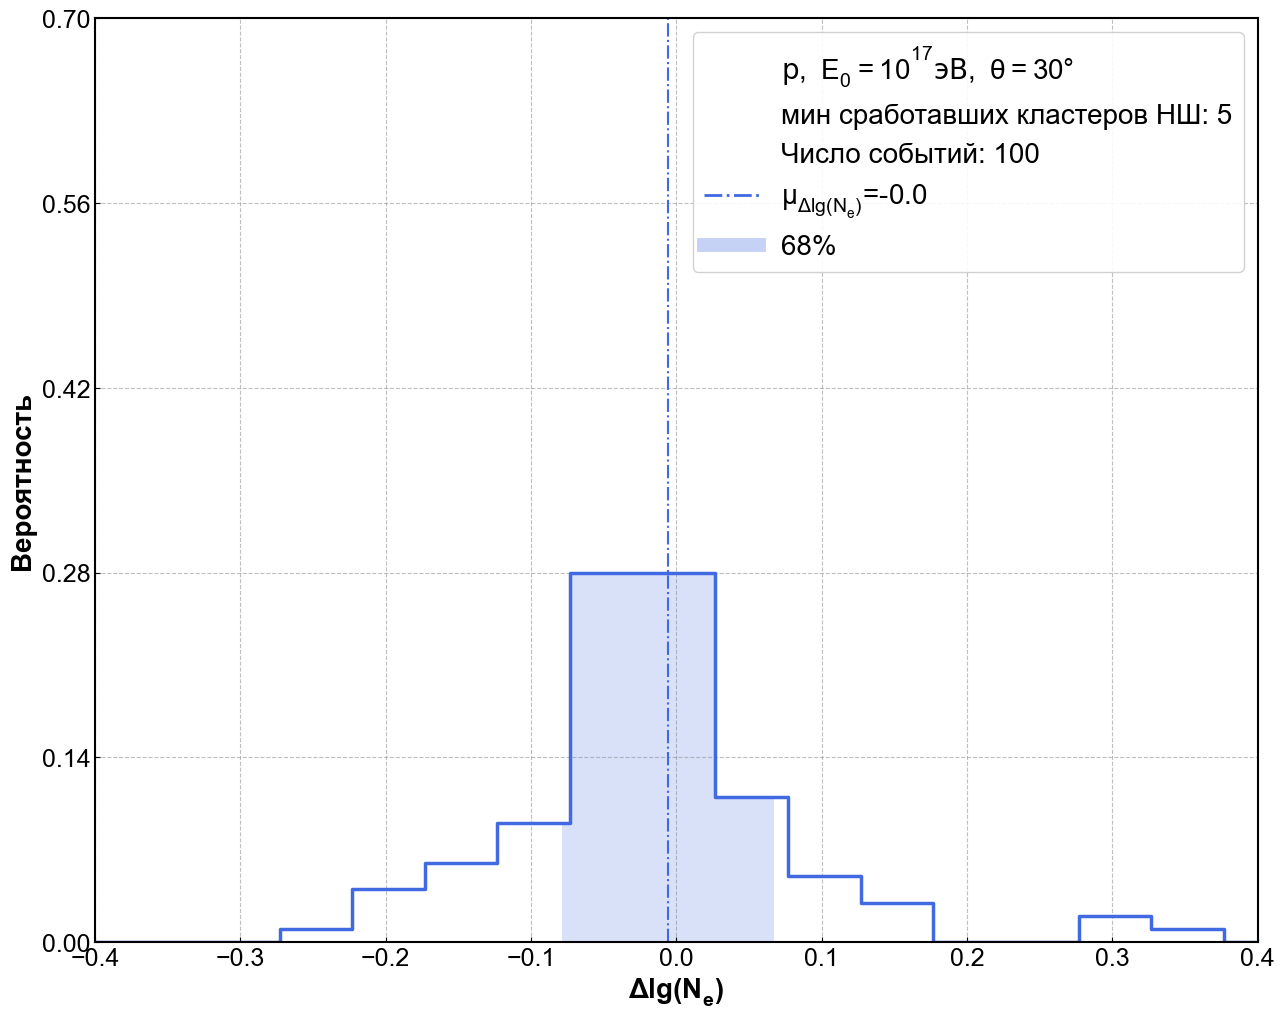

In [242]:
plot_single_distribution_Ne(arrays['Ne_opt'], arrays['Ne'], 'Ne', E, limit, bin_width, min_st, top_k, ymax, save)

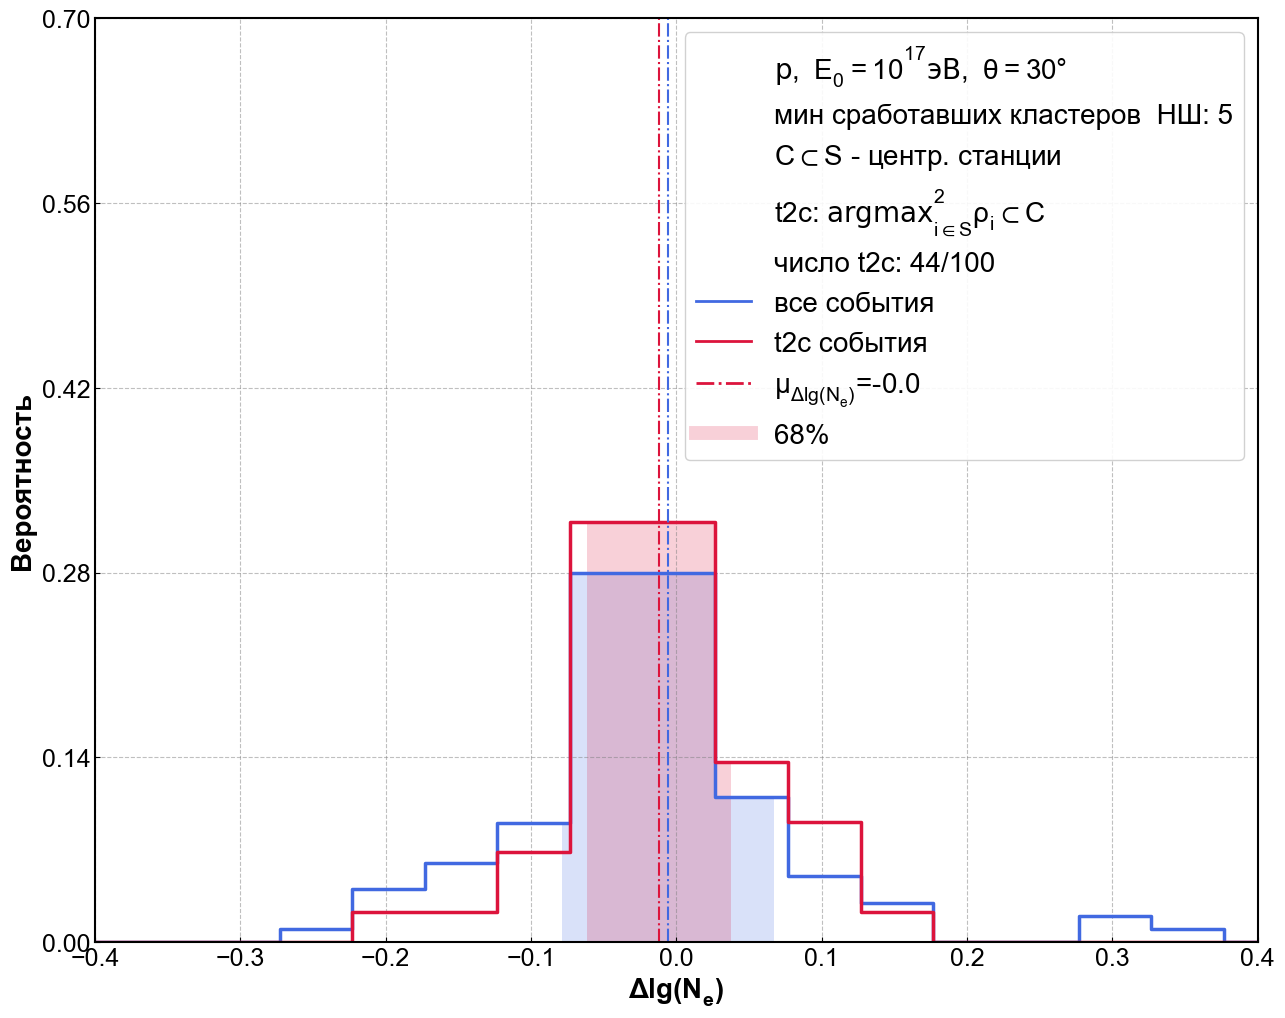

In [243]:
plot_two_distributions_Ne(arrays['Ne_opt'], arrays['Ne'], arrays['t4c_Ne_opt'], arrays['t4c_Ne'], 'Ne', E, limit, bin_width, min_st, top_k, ymax, save)

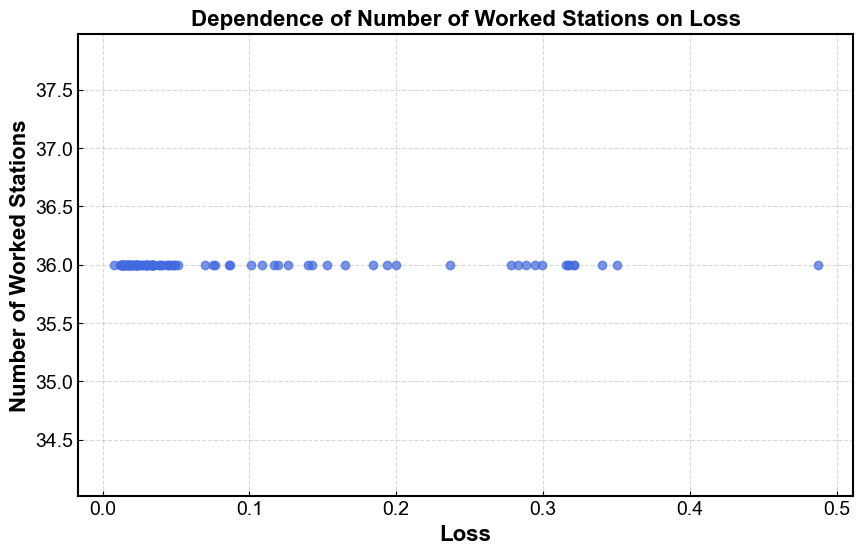

In [ ]:
stations_count = np.array([len(stations) for stations in df['worked_stations']])

loss = np.array(df['loss'])
plt.figure(figsize=(10, 6))
plt.scatter(loss, stations_count, color='royalblue', alpha=0.7)
plt.xlabel('Loss')
plt.ylabel('Number of Worked Stations')
plt.title('Dependence of Number of Worked Stations on Loss')
plt.grid(True)
plt.show()

In [ ]:
clusters = [list(range(i, i + 4)) for i in range(0, 36, 4)] 

def count_triggered_clusters(worked_stations):
    count = 0
    for cluster in clusters:
        triggered = len(set(cluster) & set(worked_stations))
        if triggered >= 2:
            count += 1
    return count

df['triggered_clusters'] = df['worked_stations'].apply(count_triggered_clusters)

plt.figure(figsize=(10, 6))
plt.hist(
    df['triggered_clusters'],
    bins=np.arange(0, 11) - 0.5,  
    edgecolor='black',
    align='mid',
    rwidth=0.8
)

legend_elements = [
        plt.Line2D([0], [0], color='none', label=rf'$\mathrm{{{PRIM_PARTICLE}}},\ E_0 = 10^{{{E}}}\text{{эВ}},\ \theta = {THETA}\degree$'),
    ]


plt.xlabel('сработавших кластеров')
plt.ylabel('Частота')
plt.xticks(range(0, 10)) 
plt.legend(handles=legend_elements, loc='best', framealpha=0.9)
plt.grid(axis='y', alpha=0.5)
folder_path = os.path.join(PLOTS_GEANT_DIR, f"{PRIM_PARTICLE}{THETA}", f"E{E}")
os.makedirs(folder_path, exist_ok=True)  
filename = os.path.join(folder_path, f"clusters_hist.png")
# plt.savefig(filename, dpi=500, bbox_inches='tight')
plt.close()
plt.show()

## $\theta = const$ 

$\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i$

$\sigma = \sqrt{\frac{1}{n - 1} \sum_{i=1}^{n} (x_i - \bar{x})^2}$

$\text{SEM} = \frac{\sigma}{\sqrt{n}}$


In [5]:
files = glob.glob(f"{RECONSTRUCTION_GEANT_OUTPUT_DIR}/*.csv")

def extract_E0(file_path):
    file_name = os.path.basename(file_path)
    return int(file_name.split('p')[1][:2])

df = pd.concat(
    (pd.read_csv(file).assign(E0=extract_E0(file)) for file in files),
    ignore_index=True
)

In [24]:
df["E_real"] = 10 ** df["E0"] 
df.head(1)

,theta,phi,X0,Y0,Ne,s,r,rho,mask,worked_clusters,...,loss,E0,E_real,delta_s,delta_X,delta_Y,delta_logNe,r_opt,delta_r,n_clusters
0,30.0,103.14099,28.654863,-1.643812,975.24255,1.406081,45.700119,"[1.1284036970720057, 0.7790800456593675, 0.391...","[False, False, False, False, False, False, Fal...",[8],...,1.052842e-32,14,100000000000000,-1.046476,16.464547,39.448501,2.180542,66.868701,21.168582,0


In [25]:
df["E_real"] = 10 ** df["E0"] 

df["delta_s"] = df["s_opt"] - df["s"]
stats_s = df.groupby("E_real")["delta_s"].agg(["mean", "std", "count"])
stats_s["sem"] = stats_s["std"] / stats_s["count"]**0.5

df["delta_X"] = df["X0_opt"] - df["X0"]
stats_x = df.groupby("E_real")["delta_X"].agg(["mean", "std", "count"])
stats_x["sem"] = stats_x["std"] / stats_x["count"]**0.5

df["delta_Y"] = df["Y0_opt"] - df["Y0"]
stats_y = df.groupby("E_real")["delta_Y"].agg(["mean", "std", "count"])
stats_y["sem"] = stats_y["std"] / stats_y["count"]**0.5

df["delta_logNe"] = np.log10(df["Ne_opt"] / df["Ne"])
stats_ne = df.groupby("E_real")["delta_logNe"].agg(["mean", "std", "count"])
stats_ne["sem"] = stats_ne["std"] / stats_ne["count"]**0.5 

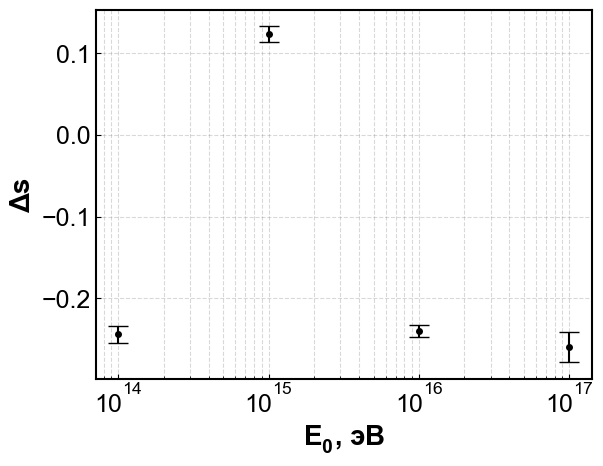

In [8]:
plt.errorbar(stats_s.index, stats_s["mean"], yerr=stats_s["sem"], fmt='o', 
             capsize=7, markersize=4, color='black')
plt.xscale('log')
plt.xlabel(r"$E_0$, эВ")
plt.ylabel(r"$\Delta s$")
plt.grid(True, which='both', ls='--')
plt.show()

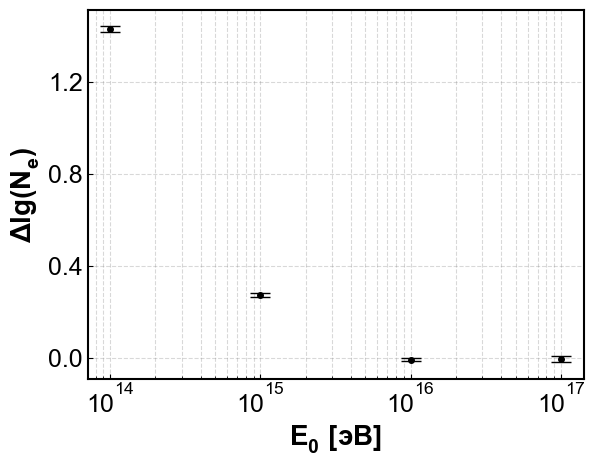

In [9]:
plt.errorbar(stats_ne.index, stats_ne["mean"], yerr=stats_ne["sem"], fmt='o', 
             capsize=7, markersize=4, color='black')
plt.xscale('log')

plt.xlabel(r"$E_0$ [эВ]")
plt.ylabel(r"$\Delta lg (N_e)$")
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=5)) 
plt.grid(True, which='both', ls='--')
plt.show()


In [26]:
df['r'] = df.apply(lambda row: compute_r(row['X0'], row['Y0'], -18, row['theta'], row['phi'], X_det, Y_det, Z_det), axis=1)
df['r_opt'] = df.apply(lambda row: compute_r(row['X0_opt'], row['Y0_opt'], -18, row['theta'], row['phi'], X_det, Y_det, Z_det), axis=1)

df['delta_r'] = df['r_opt'] - df['r']

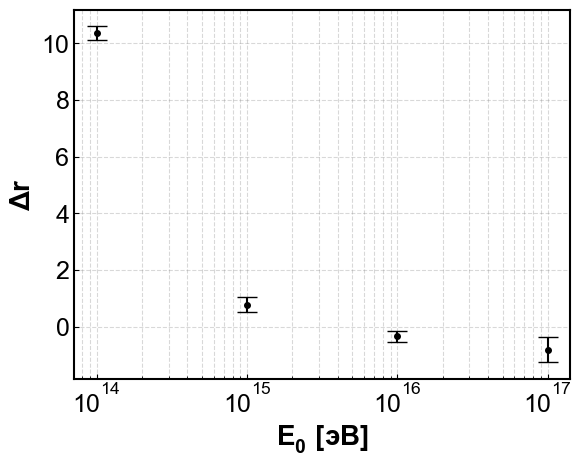

In [27]:
df['r'] = df['r'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
df['r_opt'] = df['r_opt'].apply(lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else x)
df['delta_r'] = df['r_opt'] - df['r']

stats = df.groupby('E_real')['delta_r'].agg(['mean', 'std', 'count'])
stats['sem'] = stats['std'] / np.sqrt(stats['count'])

plt.errorbar(stats.index, stats["mean"], yerr=stats["sem"], fmt='o', 
             capsize=7, markersize=4, color='black')
plt.xscale('log')

plt.xlabel(r"$E_0$ [эВ]")
plt.ylabel(r"$\Delta r$")
plt.grid(True, which='both', ls='--')
plt.show()

In [12]:
def fraction_in_range(series, lower=-0.1, upper=0.1):
    """Доля значений в диапазоне [lower, upper]."""
    return ((series >= lower) & (series <= upper)).mean()

# Для delta_s
stats_s = df.groupby("E_real")["delta_s"].agg([
    ("median", "median"),  # Медиана
    ("std", "std"),        # Стандартное отклонение
    ("count", "count"),    # Количество точек
    ("fraction_in_±10%", lambda x: fraction_in_range(x, -0.1, 0.1)),  # Доля в ±10%
    ("MAD", lambda x: (x - x.median()).abs().median())  # Среднее абсолютное отклонение
])

# Аналогично для delta_X, delta_Y, delta_logNe
stats_x = df.groupby("E_real")["delta_X"].agg([
    ("median", "median"),
    ("std", "std"),
    ("count", "count"),
    ("fraction_in_±10%", lambda x: fraction_in_range(x, -0.1, 0.1)),
    ("MAD", lambda x: (x - x.median()).abs().median())
])

stats_y = df.groupby("E_real")["delta_Y"].agg([
    ("median", "median"),
    ("std", "std"),
    ("count", "count"),
    ("fraction_in_±10%", lambda x: fraction_in_range(x, -0.1, 0.1)),
    ("MAD", lambda x: (x - x.median()).abs().median())
])

stats_ne = df.groupby("E_real")["delta_logNe"].agg([
    ("median", "median"),
    ("std", "std"),
    ("count", "count"),
    ("fraction_in_±10%", lambda x: fraction_in_range(x, -0.1, 0.1)),
    ("MAD", lambda x: (x - x.median()).abs().median())
])

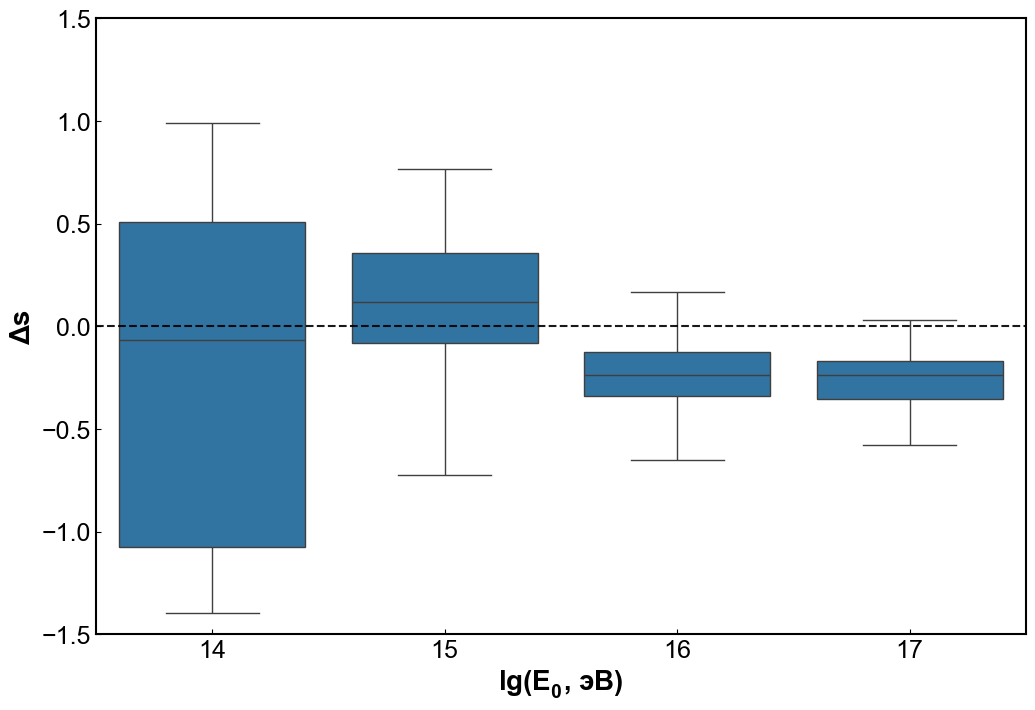

In [13]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x="E0", y="delta_s", showfliers=False) 
plt.ylim(-1.5, 1.5)
plt.axhline(0, color="black", linestyle="--", alpha=0.9)
plt.xlabel(r"$lg(E_0$, эВ)")
plt.ylabel(r"$\Delta s$")
plt.show()

In [21]:
df_filtered = df[df['worked_clusters'].apply(len) > 5]

In [22]:
print(f"Всего событий после фильтрации: {len(df_filtered)}")
print(df_filtered['n_clusters'].value_counts())

Всего событий после фильтрации: 4321
n_clusters
0    4321
Name: count, dtype: int64


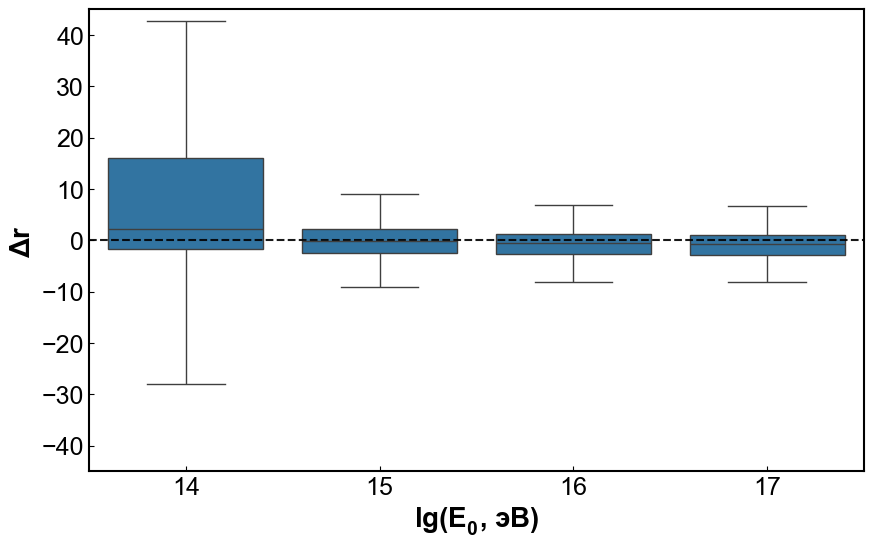

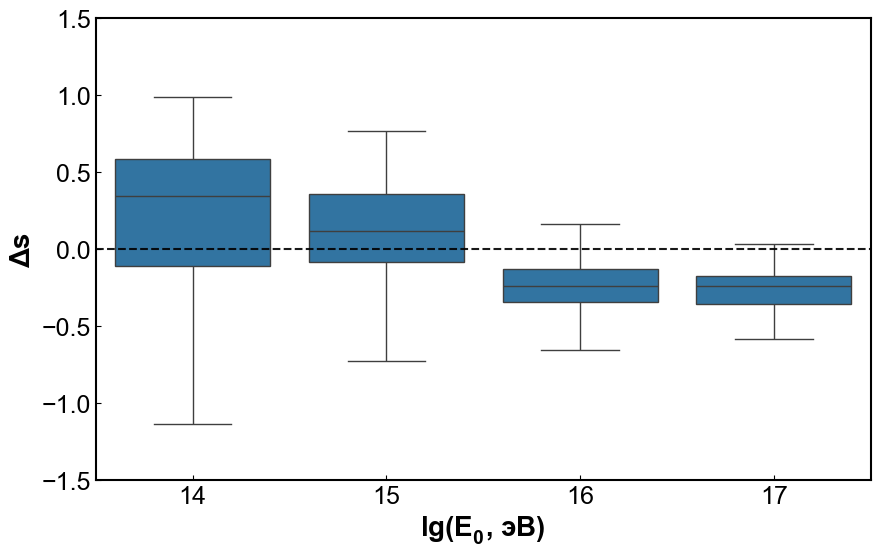

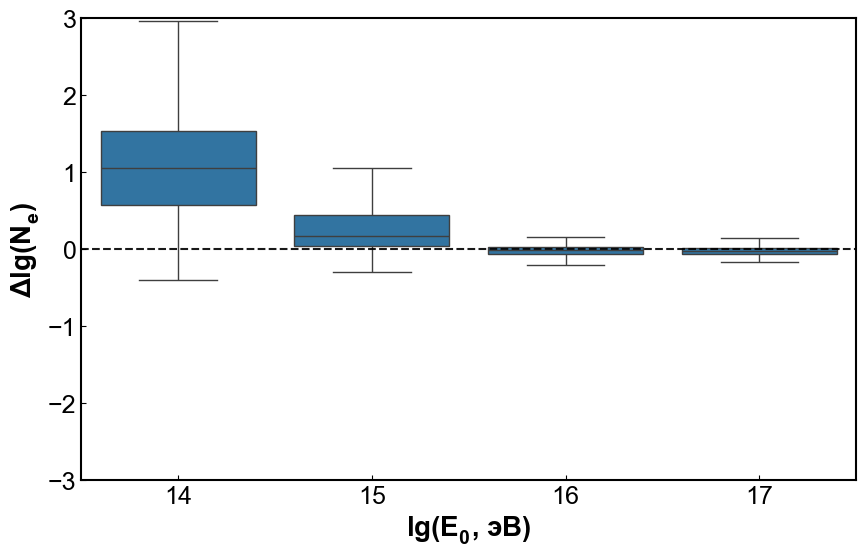

In [46]:
params = ['delta_r', 'delta_s', 'delta_logNe']
sym_limits = {'delta_r': (-45, 45), 'delta_s': (-1.5, 1.5),  'delta_logNe': (-3, 3)} 
param_labels = {
    'delta_r': r'$\Delta r$',          
    'delta_s': r'$\Delta s$',          
    'delta_logNe': r'$\Delta lg(N_e)$' 
}

for param in params:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_filtered, x='E0', y=param, showfliers=False) 
    plt.axhline(0, color='black', linestyle='--', alpha=0.9,)
    plt.ylim(sym_limits[param])  
    plt.ylabel(param)
    plt.xlabel(r"$lg(E_0$, эВ)")
    plt.ylabel(param_labels.get(param, rf"$\Delta {param.split('_')[-1]}$"))
    plt.show()

<>:40: SyntaxWarning: invalid escape sequence '\D'
<>:40: SyntaxWarning: invalid escape sequence '\D'
C:\Users\matsvei\AppData\Local\Temp\ipykernel_15040\3179625130.py:40: SyntaxWarning: invalid escape sequence '\D'
  plt.title('$|\Delta r| < 15$, $|\Delta \log_{10}N_e| < 0.3$, $\dfrac{|\Delta s|}{s} < 0.3$ ',
C:\Users\matsvei\AppData\Local\Temp\ipykernel_15040\3179625130.py:19: RuntimeWarning: invalid value encountered in divide
  ratios = sel_counts / all_counts


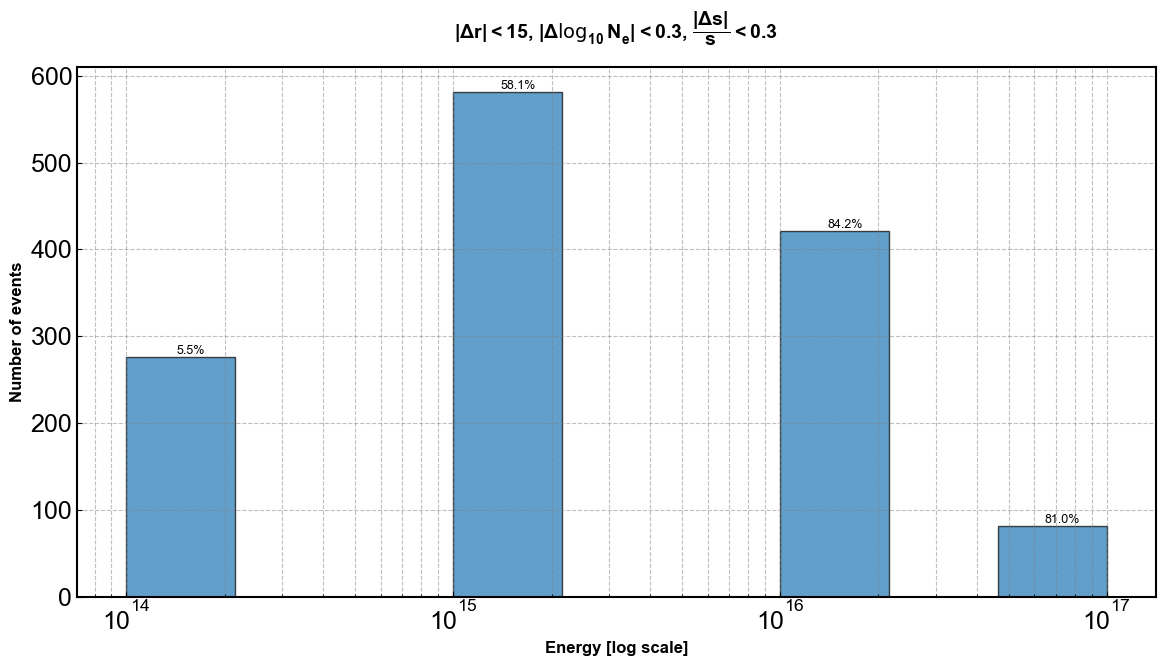

In [ ]:
filter_mask = (np.abs(df['delta_r']) < 15) & (np.abs(df['delta_logNe']) < 0.3) & (np.abs(df['delta_s']) / df['s'] < 0.3)
filtered_events = df[filter_mask]

energy_bins = np.logspace(np.log10(df['E_real'].min()), 
                         np.log10(df['E_real'].max()), 
                         10)  # 10 бинов


all_counts, _ = np.histogram(df['E_real'], bins=energy_bins)

sel_counts, bin_edges = np.histogram(filtered_events['E_real'], bins=energy_bins)
ratios = sel_counts / all_counts
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(12, 7))

# Основная гистограмма
bars = plt.bar(bin_centers, sel_counts, 
              width=np.diff(bin_edges),
              edgecolor='k', alpha=0.7,
              label=f'Selected events (total={len(filtered_events)})')

for i, (x, ratio, count) in enumerate(zip(bin_centers, ratios, sel_counts)):
    if all_counts[i] > 0: 
        plt.text(x, count, f'{ratio:.1%}', 
                ha='center', va='bottom', fontsize=9)

plt.xscale('log')
plt.xlabel('Energy [log scale]', fontsize=12)
plt.ylabel('Number of events', fontsize=12)
plt.title('$|\Delta r| < 15$, $|\Delta \log_{10}N_e| < 0.3$, $\dfrac{|\Delta s|}{s} < 0.3$ ',
          fontsize=14, pad=20)
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [2]:
full_path = os.path.join(READ_GEANT_OUTPUT_DIR, 'spe27.csv')
last100_path = os.path.join(READ_GEANT_OUTPUT_DIR, 'spe27.csv')


with open(full_path , 'r') as f:
    header = f.readline()                     # читаем первую строку (заголовок)
    last_lines = list(deque(f, 1000))          # читаем последние 100 строк

with open(last100_path, 'w') as f:
    f.write(header)                           # сначала записываем заголовок
    f.writelines(last_lines)  